## Static dataset creation
This notebook walks through how to use the modules to create and save a static dataset for use in all of the statistical and ML methods. The method-focused notebooks show how to import and utilize this static dataset in inference.

In [60]:
import numpy as np
import jax.numpy as jnp
from deepbench.physics_object import Pendulum
import pandas as pd
import matplotlib.pyplot as plt

In [54]:
import sys
sys.path.append('..')
from src.scripts import analysis

In [46]:

def save_thetas_and_xs_multiple(params_in):
    # except length will have 4 elements
    lengths, thetas, μ_a_g, σ_a_g = params_in

    ag0 = rs.normal(loc=μ_a_g, scale=σ_a_g)
    ag1 = rs.normal(loc=μ_a_g, scale=σ_a_g)
    ags = np.array([np.repeat(ag0,int(len(lengths)/2)), np.repeat(ag1,int(len(lengths)/2))]).flatten()
    #ags = np.array([rs.normal(loc=μ_a_g, scale=σ_a_g, size = int(len(lengths)/2)),
    #       rs.normal(loc=μ_a_g, scale=σ_a_g, size = int(len(lengths)/2))]).flatten()
    
    
    xs = []
    for i in range(len(lengths)):
        #print(lengths[i], thetas[i], ags[i])
        pendulum = Pendulum(
                    pendulum_arm_length=float(lengths[i]),
                    starting_angle_radians=float(thetas[i]),
                    acceleration_due_to_gravity=float(ags[i]),
                    noise_std_percent={
                        "pendulum_arm_length": 0.0,
                        "starting_angle_radians": 0.1,
                        "acceleration_due_to_gravity": 0.0,
                    },
                )
        x = pendulum.create_object(0.75, noiseless=False)
        xs.append(x)
        del pendulum
    return ags, xs

In [47]:
#length0, length1, length2, length3, theta0, theta1, theta2, theta3, μ_a_g, σ_a_g = thetas_in
length_percent_error_all = 0.0
theta_percent_error_all = 0.1
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

total_length = 1000
length_df = int(total_length/4) # divide by four because we want the same total size as above

pendulums_per_planet = 100

# and we get four pendulums per iteration of the below
thetas = np.zeros((total_length, 5))
# this needs to have the extra 1 so that SBI is happy
xs = np.zeros((total_length,1))
#labels = np.zeros((2*length_df, 2))
#error = []
#y_noisy = []

    
rs = np.random.RandomState()#2147483648)# 


lengths_draw = abs(rs.normal(loc=5, scale=2, size = pendulums_per_planet))
thetas_draw = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/500, size = pendulums_per_planet))

μ_a_g = abs(rs.normal(loc=10, scale=2))
σ_a_g = abs(rs.normal(loc=1, scale=0.5))


params_in = [lengths_draw,
             thetas_draw,
             μ_a_g, σ_a_g]

a_gs, xs_out = save_thetas_and_xs_multiple(params_in)



In [50]:
# now make it into a dataframe
data_params = {
    'length': lengths_draw,
    'theta': thetas_draw,
    'a_g': a_gs,
    'time': np.repeat(time, len(lengths_draw)),
    'pos': xs_out,
    
}

## create the DataFrame
df = pd.DataFrame(data_params)
df

,length,theta,a_g,time,pos
0,5.939540,0.040323,10.348500,0.75,0.126648
1,3.645948,0.041587,10.348500,0.75,0.046904
2,4.494573,0.032681,10.348500,0.75,0.066548
3,3.691717,0.032449,10.348500,0.75,0.036753
4,8.463276,0.026023,10.348500,0.75,0.124928
...,...,...,...,...,...
95,3.287364,0.027606,9.821157,0.75,0.027284
96,4.901377,0.031559,9.821157,0.75,0.080431
97,6.374146,0.028311,9.821157,0.75,0.102336
98,1.075661,0.030635,9.821157,0.75,-0.023095


## Also add a column for the position error
Recall, this is an analytic expectation. It is calculated using the input percent error on the $\theta_0$ parameter and the `calc_error_prop` function in the `analysis.py` module.

In [58]:
df['pos_err'] = analysis.calc_error_prop(df['length'],
                         df['theta'],
                         df['a_g'],
                         0.1*df['theta'],
                         df['time'],
                         wrt='theta_0')
df

,length,theta,a_g,time,pos,pos_err
0,5.939540,0.040323,10.348500,0.75,0.126648,0.013138
1,3.645948,0.041587,10.348500,0.75,0.046904,0.004585
2,4.494573,0.032681,10.348500,0.75,0.066548,0.006160
3,3.691717,0.032449,10.348500,0.75,0.036753,0.003712
4,8.463276,0.026023,10.348500,0.75,0.124928,0.014872
...,...,...,...,...,...,...
95,3.287364,0.027606,9.821157,0.75,0.027284,0.002459
96,4.901377,0.031559,9.821157,0.75,0.080431,0.007539
97,6.374146,0.028311,9.821157,0.75,0.102336,0.010773
98,1.075661,0.030635,9.821157,0.75,-0.023095,0.002111


## And of course, double check that this makes sense by looking at the data
I think it's especially useful to double check the expected analytic error as a function of whatever parameter you're introducing it on.

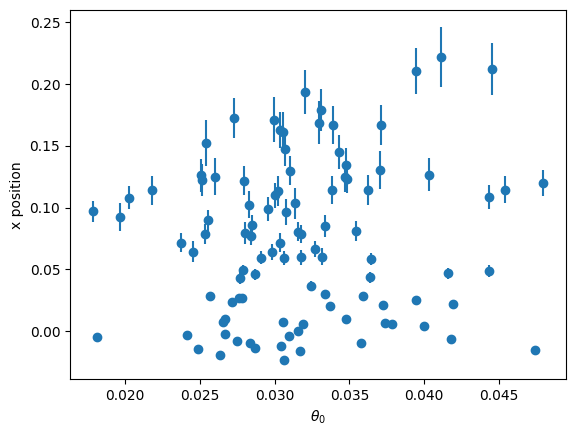

In [64]:
plt.clf()
plt.scatter(df['theta'], df['pos'])
plt.errorbar(df['theta'], df['pos'], yerr = df['pos_err'], ls = 'None')
plt.xlabel(r'$\theta_0$')
plt.ylabel('x position')
plt.show()

In [65]:
# save the dataframe
filepath = '../data/'
df.to_csv(filepath+'static_hierarchical_df.csv')